# Evolution of Binary Black Hole using Brill Lindquist Initial Data

This notebook is a self-contained notebook to create black holes and evolving them based on the Baumgarte-Shapiro-Shibata-Nakamura (BSSN) formalism and Brill Lindquist Initial data using only Python and Python packages (although some of the packages used are using C for optimization, this notebook only uses the Python language). Inspired by the NRPy project by Ruchlin, Etienne, and Baumgarte, 2018. 

To run this notebook, you will need these packages installed:
* Jupyter
* PyTorch (with CUDA to enable GPU Acceleration, will default to CPU if not)
* NumPy
* Matplotlib

In [33]:
# Packages for computation and visualization.
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
import string

# Check if CUDA is available for GPU acceleration.
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'

print(f"Current device: {device}")
torch.set_default_device(device)
torch.set_default_dtype(torch.float64)

# Packages for optimizaiton, storage, and visualization.
import gc, os, shutil
import time
from datetime import datetime
from IPython.display import HTML
from pathlib import Path

# Get the current date and time for folder name.
current_date = datetime.now().strftime("%Y%m%d-%H%M%S")

Current device: cuda


## Parameters
This section contains the parameters that can be chosen for the evolution. There is a different section for choosing what variables to save in the **Save File** section. 

### Grid parameters

`n_grid` defines the computational grid size and `resolution` defines the spacing between grids. This will create a computational domain with `min(x) = -resolution * (n_grid/2 - 1)` and `max(x) = resolution * (n_grid/2 - 1)`

In [34]:
# Grid choice
n_grid = 64
resolution = 1/8

### Black hole parameters

`BH_locs` defines the black hole's locations, the number of list inside the list defines how many black holes there are. `BH_masses` defines the black hole's respective massess. Lastly, the `initial_lapse` defines the initial data for the lapse, $\alpha = e^{-2\phi}$ for the precollapsed lapse which is good for moving punctures as suggested by Campanelli et al., 2006.

In [35]:
# Black hole choice
BH_locs = [[0.0, 0.0, 0.5], [0.0, 0.0, -0.5]]
BH_masses = [0.5, 0.5]
initial_lapse = "precollapsed" # The choices are "ones" or "precollapsed"

### Evolution parameters
There are a few choices for the evolution parameters. First is the `temporal_differencing` variable defines the choice for the temporal differencing method, `"RK4"` for 4th order Runge-Kutta and `"ICN"` for Iterative Crank-Nicholson (see **Evolving the Variables** section for more details). Second, the `t_final` variable defines the final time of the simulation, even though it will crash even before that, safety first. Lastly, the `CF` variable defines the Courant Factor for the temporal differencing resolution, usually `1/2` or `1/4` (see **The Grid** section for more details). 

In [36]:
# Evolution parameters
temporal_differencing = "RK4" # The choices are "RK4" or "ICN"
t_final = 500
CF = 1/2 # Courant Factor

### BSSN parameters

The gauges' evolution has a few variables that can me modified. First, the `lambdas` variable changes the gauge's advection terms (e.g. `lambdas = [0, 1, 1, 1]` will make $\lambda_1 = 0$ turning $\partial_t \alpha = -\alpha^2 f_1(\alpha)K$. Second, the `damping` variable changes the $\eta$ value. Third, the `f1_alpha` and `f2_alpha` variables changes the $f_1(\alpha)$ and $f_2(\alpha)$ respectively. The gauges' evolution equations are defined as defined by Cao (2008) below and can be changed to find the suitable choices from Cao (2008) themselves, Bruegmann et al. (2008), or van Meter et al. (2006).
\begin{align}
\partial_t \alpha & = -\alpha^2 f_1(\alpha) K + \lambda_1 \beta^i\alpha_{,i},\\
\partial_t \beta^i & = \frac{3}{4} f_2(\alpha) B^i + \lambda_2 \beta^j\beta^i_{,j},\\
\partial_t B^i & = \partial_t\bar\Gamma^i - \eta B^i + \lambda_3\beta^j B^i_{,j} - \lambda_4 \beta^j \bar\Gamma^i_{,j}.
\end{align}

During the evolution, we can enforce the constraints using these equations if `enforce_constraints = True` (Cao, 2008)
\begin{align}
\bar\gamma_{ij} & \rightarrow \bar\gamma^{-1/3}\bar\gamma_{ij}, \\
\bar A_{ij} & \rightarrow \bar A_{ij} - \frac{1}{3}\bar\gamma_{ij}\text{tr}\bar A_{ij}, \\
\bar\Gamma^i & \rightarrow \bar\gamma^{ij}_{,j}.
\end{align}
Note that $\bar\Gamma^{i}$ are only enforced for the undifferentiated $\bar\Gamma^{i}$ in the evolution equations.

We can also choose which conformal variable to choose by setting `conformal_variable` to `"phi"` for $\phi$, `"chi"` for $\chi = e^{-4\phi}$, and `"W"` for $W = e^{-2\phi}$. The `epsilon` variable will take care of $\ln{0}$ by replacing the values of $\chi$ or $W$ that are less than `epsilon` with `epsilon`.


In [37]:
# BSSN parameters
damping = 2 # Eta
lambdas = [1, 1, 1, 1]
f1_alpha = "2/alpha" # The choices are "ones", "2/alpha", "alpha", or "alpha^2"
f2_alpha = "ones" # The choices are "ones", "2/alpha", "alpha", or "alpha^2"
enforce_constraints = True
conformal_variable = "phi" # Choose which variable to evolve, "phi", "chi", or "W"
epsilon = 1e-8 # If chi or W is chosen, avoid ln(0) by replacing it with this value.

### Visual parameters

`cmap` defines the colormap that will be used for the preview and animation and is based on Matplotlib's colormap. `preview` defines which conformal variable to preview in the **Preview** section. `fps` defines the framerate for the animation, it will be converted into millisecond using `1/fps * 1000`. `animate` defines which conformal variable to animate in the **Visualization** section.

In [38]:
# Visual parameters
cmap = "plasma" # Colormap
preview = "W" # Choose which variable to preview, "phi", "chi", or "W"
fps = 30
animate = "phi" # Choose which variable to animate, only for saved variables in the .npz file

### Save parameters
Saving the parameters into a .txt file for documentation purposes. The same folder will be used to store the evolution files.

In [39]:
# Folder to save the evolution files
folder = f'./Data/{current_date}_{n_grid}'

# Create folder if it does not exist
if not os.path.exists(folder):
    os.makedirs(folder)
else:
    shutil.rmtree(folder)
    os.makedirs(folder)

# Save the parameters into the folder
with open(f"{folder}/parameters.txt", "w") as w:
    w.write(f"""Parameters for {current_date}
Grid choice:
n_grid = {n_grid}
resolution = {resolution}

Black hole choice:
BH_locs = {BH_locs}
BH_masses = {BH_masses}

Evolution choice:
temporal_differencing = {temporal_differencing}
CF = {CF}

BSSN parameters:
damping = {damping}
lambdas = {lambdas}
f1_alpha = {f1_alpha}
f2_alpha = {f2_alpha}
enforce_constraints = {enforce_constraints}
conformal_variable = {conformal_variable}
epsilon = {epsilon}""")

## Variables
In this section we define variables that are required to calculate the evolution equations. These variables are defined globally. We use slicing to indicate that these variables are being changed (e.g. `alpha[:] = torch.exp^{-2 * \phi}` or `gamma_bar_mat_lo[:,:,:] = minkowski`). 

In [40]:
# Gauge
alpha = torch.zeros((n_grid, n_grid, n_grid))
beta = torch.zeros((n_grid, n_grid, n_grid, 3))
B = torch.zeros((n_grid, n_grid, n_grid, 3))

# Metric
phi = torch.zeros((n_grid, n_grid, n_grid))
gamma_mat_up = torch.zeros((n_grid, n_grid, n_grid, 3, 3))
gamma_mat_lo = torch.zeros((n_grid, n_grid, n_grid, 3, 3))
gamma_bar_mat_up = torch.zeros((n_grid, n_grid, n_grid, 3, 3))
gamma_bar_mat_lo = torch.zeros((n_grid, n_grid, n_grid, 3, 3))

# Connection Coefficients
Gamma_bar = torch.zeros((n_grid, n_grid, n_grid, 3))
Gamma_mat_up = torch.zeros((n_grid, n_grid, n_grid, 3, 3, 3))
Gamma_mat_lo = torch.zeros((n_grid, n_grid, n_grid, 3, 3, 3))
Gamma_bar_mat_up = torch.zeros((n_grid, n_grid, n_grid, 3, 3, 3))
Gamma_bar_mat_lo = torch.zeros((n_grid, n_grid, n_grid, 3, 3, 3))

# Extrinsic Curvature
A_bar_mat_up = torch.zeros((n_grid, n_grid, n_grid, 3, 3))
A_bar_mat_lo = torch.zeros((n_grid, n_grid, n_grid, 3, 3))
A_TT_bar_mat_up = torch.zeros((n_grid, n_grid, n_grid, 3, 3))
A_L_bar_mat_up = torch.zeros((n_grid, n_grid, n_grid, 3, 3))

K = torch.zeros((n_grid, n_grid, n_grid))
K_mat_lo = torch.zeros((n_grid, n_grid, n_grid, 3, 3))

# Ricci tensor
R_mat_lo = torch.zeros((n_grid, n_grid, n_grid, 3, 3))
R_bar_mat_lo = torch.zeros((n_grid, n_grid, n_grid, 3, 3))
R_phi_mat_lo = torch.zeros((n_grid, n_grid, n_grid, 3, 3))

# Stress Energy
rho = torch.zeros((n_grid, n_grid, n_grid))
S = torch.zeros((n_grid, n_grid, n_grid, 3))
S_mat_lo = torch.zeros((n_grid, n_grid, n_grid, 3, 3))

## Calculate Initial Data
We initialize the grid and initial data in this part of the code.

### The Grid

This part of the code generates the grid from `min(x) = resolution * (1 - n_grid/2)` to `max(x) = resolution * (n_grid/2 - 1)`.

For the simulation stability, the time step must fulfill the condition (Baumgarte and Shapiro, 2021)
$$\Delta t < \frac{\mathrm{CF}}{v_c} \Delta x.$$
Therefore
$$\Delta t = \mathrm{CF} \Delta x$$
with $v_c = 1$.


In [41]:
# Create the space
np_space = np.linspace(resolution * (1 - n_grid/2), resolution * (n_grid/2 - 1), n_grid)

x = torch.from_numpy(np_space).to(device)
y = torch.from_numpy(np_space).to(device)
z = torch.from_numpy(np_space).to(device)

X, Y, Z = torch.meshgrid(x, y, z, indexing="xy")

dx = resolution
dt = CF * dx
count = int(t_final/dt)

print(f"dx = {dx}, dt = {dt}, x_out = {torch.max(x).item()}")
print(f"Steps: {count}")

dx = 0.125, dt = 0.0625, x_out = 3.875
Steps: 8000


### The Black Hole
In this section we set the initial data using Brill Lindquist initial data (Baumgarte and Shapiro, 2010)

\begin{align}
\psi & = 1 + \sum_a \frac{M_a}{2r_a}, \\
\beta^i & = 0, \\
K = K_{ij} & = 0, \\ 
\rho = S^i & = 0. \\
\end{align}

The $\psi$ is then converted into the chosen conformal variable (Shibata, 2015)

\begin{align}
\phi & = \ln{\psi},\\
\chi & = e^{-4\phi},\quad \text{or}\\
W & = e^{-2\phi}.
\end{align}

In [42]:
# Brill-Lindquist initial data.
psi = 1.0
for loc, mass in zip(BH_locs, BH_masses):
    psi += mass/(2 * torch.sqrt((X - loc[0])**2 + (Y - loc[1])**2 + (Z - loc[2])**2))

phi[:] = torch.log(psi)

if conformal_variable == "chi":
    chi = torch.exp(-4 * phi)
elif conformal_variable == "W":
    W = torch.exp(-2 * phi)

# Initialize the gauge.
if initial_lapse == "precollapsed":
    alpha[:] = torch.exp(-2 * phi)
elif initial_lapse == "ones":
    alpha[:] = 1

beta[:] = torch.zeros((n_grid, n_grid, n_grid, 3))
B[:] = torch.zeros((n_grid, n_grid, n_grid, 3))

# K = K_{ij} = 0 therefore \bar A_{ij} = 0. We only need to specify that K, A_L, A_TT to be 0.
K[:] = torch.zeros((n_grid, n_grid, n_grid))
A_TT_bar_mat_up[:] = torch.zeros((n_grid, n_grid, n_grid, 3, 3))
A_L_bar_mat_up[:] = torch.zeros((n_grid, n_grid, n_grid, 3, 3))

# Vacuum condition.
rho[:] = torch.zeros((n_grid, n_grid, n_grid))
S[:] = torch.zeros((n_grid, n_grid, n_grid, 3))
S_mat_lo[:] = torch.zeros((n_grid, n_grid, n_grid, 3, 3))

### Preview
Preview the black hole.

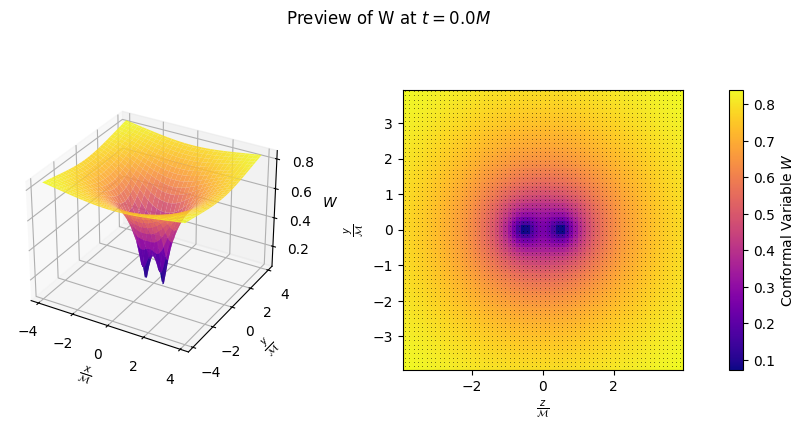

In [43]:
fig = plt.figure(figsize=(12, 8))
fig.suptitle(f"Preview of {preview} at $t = 0.0M$")

if preview == "phi":
    func = phi[:, n_grid//2, :].cpu()
elif preview == "chi":
    func = torch.exp(-4 * phi[:, n_grid//2, :]).cpu()
elif preview == "W":
    func = torch.exp(-2 * phi[:, n_grid//2, :]).cpu()

# 2D Colormesh
ax1 = fig.add_subplot(2, 1, 1)
mesh = ax1.pcolormesh(Z[:, 0, :].cpu(), 
                      Y[:, 0, :].cpu(), 
                      func, 
                      cmap=cmap, shading="nearest")

# The grid dots
ax1.plot(Z.cpu().numpy()[:, 0, :].flat, 
         Y.cpu().numpy()[:, 0, :].flat, 
         ',k', alpha=0.5)

ax1.set_xlabel(r"$\frac{z}{\mathcal{M}}$")
ax1.set_ylabel(r"$\frac{y}{\mathcal{M}}$")
ax1.set_aspect("equal", "box")

# 3D Surface Plot
ax2 = fig.add_subplot(2, 2, 1, projection='3d')
surface = ax2.plot_surface(Z[:, 0, :].cpu(), 
                           Y[:, 0, :].cpu(), 
                           func, 
                           cmap=cmap, antialiased=True, alpha=0.8)

ax2.set_xlabel(r'$\frac{x}{\mathcal{M}}$')
ax2.set_ylabel(r'$\frac{y}{\mathcal{M}}$')
ax2.set_zlabel(r'$W$')

cb = plt.colorbar(mesh)
cb.set_label(r"Conformal Variable $W$")

plt.show()

### Save File

This function saves the variable into a .npz file. If you would like to save other variables, modify the code.

In [44]:
def write_to_file(filename):
    """
    This function saves the variables into a .npz file. If you would like to
    save other variables, modify the code.
    """

    # Unomment to save, comment to not save.
    np.savez_compressed(f"{filename}",
            X=X.cpu().numpy(),
            Y=Y.cpu().numpy(),
            Z=Z.cpu().numpy(),
            phi=phi.cpu().numpy(),
            alpha=alpha.cpu().numpy(),
            #K=K.cpu().numpy(),
            #gamma_bar_mat_lo=gamma_bar_mat_lo.cpu().numpy(),
            #A_bar_mat_lo=A_bar_mat_lo.cpu().numpy(),
            #Gamma_bar=Gamma_bar.cpu().numpy(),
            #alpha=alpha.cpu().numpy(),
            #beta=beta.cpu().numpy(),
            #B=B.cpu().numpy()),
    )

## Calculate the Variables
In this section we define the functions to calculate and change the variables. The functions here (except for the finite difference) will not return the values but will change the values directly. See the **Variables** section for more information. Other than that, to calculate the fields, we use PyTorch's einsum method to do Einstein summation.

### Finite Difference
In this section we define the functions of the spatial finite difference that are used in this simulation. The centered finite difference will be performed by using PyTorch's gradient function and the lopsided finite difference will be defined manually.

In [45]:
def one_spatial_deriv(func):
    """
    Calculate the spatial derivation d_i.

    Returns a tensor with the shape of (*func.shape, 3) 
    """

    diff = torch.stack(torch.gradient(func, spacing=[x, y, z], dim=[0,1,2], edge_order=1), dim=0)

    n_indices = len(diff.shape)-3
    labels = string.ascii_lowercase[:n_indices]

    diff_ordered = torch.einsum(f"{labels[-1]}xyz{labels[:n_indices-1]}->xyz{labels}",diff)

    return diff_ordered


def two_spatial_deriv(func):
    """
    Calculate the spatial derivation d_i d_j.

    Returns a tensor with the shape of (*func.shape, 3, 3) 
    """

    diff = torch.stack(torch.gradient(one_spatial_deriv(func), spacing=[x, y, z], dim=[0,1,2], edge_order=1), dim=0)

    n_indices = len(diff.shape)-3
    labels = string.ascii_lowercase[:n_indices]

    diff_ordered = torch.einsum(f"{labels[-1]}xyz{labels[:n_indices-1]}->xyz{labels}",diff)

    return diff_ordered

The advection term, $\beta^k\partial_k F$, requires a special kind of finite difference (Shibata, 2015). Alcubierre et al. (2003) found that the use of an upwind finite differencing scheme is crucial for the stability of the simulation.

This is the fourth-order lopsided spatial derivation scheme defined as
\begin{align}
\partial_x F_{i,j,k} & = \frac{1}{12 dx} (F_{i+3,j,k} - 6 F_{i+2,j,k} + 18 F_{i+1,j,k} - 10 F_{i,j,k} - 3 F_{i-1,j,k}),\quad \text{for } \beta^x > 0\\
\partial_x F_{i,j,k} & = \frac{-1}{12 dx} (F_{i-3,j,k} - 6 F_{i-2,j,k} + 18 F_{i-1,j,k} - 10 F_{i,j,k} - 3 F_{i+1,j,k}),\quad \text{for } \beta^x < 0.
\end{align}

In the case of the $\beta^x > 0$, we replace the derivation equation for indices that does not support fourth-order spatial derivation 
\begin{align}
\partial_x F_{i,j,k} & = \frac{1}{dx} (F_{i+1,j,k} - F_{i,j,k}), \\
\partial_x F_{i,j,k} & = \frac{2}{dx} (-F_{i+2,j,k} + 4 F_{i+1,j,k} - 3 F_{i,j,k}).
\end{align}
In the case of $\beta^x < 0$,
\begin{align}
\partial_x F_{i,j,k} & = \frac{-1}{dx} (F_{i-1,j,k} - F_{i,j,k}), \\
\partial_x F_{i,j,k} & = \frac{-2}{dx} (-F_{i-2,j,k} + 4 F_{i-1,j,k} - 3 F_{i,j,k}).
\end{align}
In the case where the it isn't possible to use the lopsided spatial derivation scheme such as the last index for $\beta^x > 0$ in which we are forced to use the derivation scheme of $\beta^x < 0$, we set the derivation to $0$ instead. Lastly, we use the centered finite difference in the case where $\beta^x = 0$.


In [46]:
def lopsided_one_spatial_deriv(func, side):
    """
    Calculate the lopsided spatial derivation d_i.

    The forward scheme computes F_{i+3,j,k} - ... and
    the backward scheme computes -F_{i-3,j,k} + ... 

    Returns a tensor with the shape of (*func.shape, 3) 
    """

    diff = torch.zeros((*func.shape, 3))

    if side == "forward":
        roll = [-1, -2, -3, 1]
        idx = [0, -1, -2, -3]
        coeff = 1
    elif side == "backward":
        roll = [1, 2, 3, -1]
        idx = [1, 2, 3, -1]
        coeff = -1

    for j in range(3):
        func_s1 = torch.roll(func, roll[0], dims=j) # Shift 1
        func_s2 = torch.roll(func, roll[1], dims=j) # Shift 2
        func_s3 = torch.roll(func, roll[2], dims=j) # Shift 3
        func_o1 = torch.roll(func, roll[3], dims=j) # Other shift 1

        diff[...,j] = coeff * 1/(12 * dx) * (func_s3 - 6 * func_s2 + 18 * func_s1 - 10 * func - 3 * func_o1)

        other_1 = coeff * 1/dx * (func_s1 - func)
        shift_1 = coeff * torch.zeros_like(other_1)
        shift_2 = coeff * 1/dx * (func_s1 - func)
        shift_3 = coeff * 1/(2 * dx) * (-func_s2 + 4 * func_s1 - 3 * func)

        if j == 0:
            diff[idx[0], :, :, ..., j] = other_1[idx[0], :, :, ...]
            diff[idx[1], :, :, ..., j] = shift_1[idx[1], :, :, ...]
            diff[idx[2], :, :, ..., j] = shift_2[idx[2], :, :, ...]
            diff[idx[3], :, :, ..., j] = shift_3[idx[3], :, :, ...]
        elif j == 1:
            diff[:, idx[0], :, ..., j] = other_1[:, idx[0], :, ...]
            diff[:, idx[1], :, ..., j] = shift_1[:, idx[1], :, ...]
            diff[:, idx[2], :, ..., j] = shift_2[:, idx[2], :, ...]
            diff[:, idx[3], :, ..., j] = shift_3[:, idx[3], :, ...]
        elif j == 2:
            diff[:, :, idx[0], ..., j] = other_1[:, :, idx[0], ...]
            diff[:, :, idx[1], ..., j] = shift_1[:, :, idx[1], ...]
            diff[:, :, idx[2], ..., j] = shift_2[:, :, idx[2], ...]
            diff[:, :, idx[3], ..., j] = shift_3[:, :, idx[3], ...]

    return diff

def advection_one_spatial_deriv(func, beta):
    """
    Masaru Shibata - Numerical Relativity Section 3.2 Handling advection terms.
    """
    diff = one_spatial_deriv(func)
    diff_forward = lopsided_one_spatial_deriv(func, side="forward")
    diff_backward = lopsided_one_spatial_deriv(func, side="backward")

    # Advection part
    diff_advection = torch.zeros_like(diff)
    for i in range(3):
        diff_advection[...,i][beta[...,i] <= 0] = diff_backward[...,i][beta[...,i] <= 0]
        diff_advection[...,i][beta[...,i] >= 0] = diff_forward[...,i][beta[...,i] >= 0]
        diff_advection[...,i][beta[...,i] == 0] = diff[...,i][beta[...,i] == 0]

    return diff_advection

### Metric and Conformal Metric
Calculating $\gamma_{ij}$, $\gamma^{ij}$, $\bar\gamma_{ij}$, and $\bar\gamma^{ij}$ using these equations:

\begin{align}
\bar\gamma_{ij} & = \eta_{ij} \\
\bar\gamma^{ij} & = (\bar\gamma_{ij})^{-1} \\
\gamma_{ij} & = e^{4\phi}\bar\gamma_{ij} \\
\gamma^{ij} & = e^{-4\phi}\bar\gamma^{ij} \\
\end{align}

In [47]:
def calc_gamma_bar_mat_lo():
    """
    This calculation will only be performed once for the initial data 
    because it's part of the evolution d/dt gamma_bar_mat_lo.
    """
    minkowski = torch.tensor([[1, 0, 0], 
                              [0, 1, 0], 
                              [0, 0, 1]])

    gamma_bar_mat_lo[:,:,:] = minkowski

def calc_gamma_bar_mat_up():
    gamma_bar_mat_up[:] = torch.linalg.inv(gamma_bar_mat_lo)

def calc_gamma_mat_lo():
    gamma_mat_lo[:] = torch.einsum('xyz,xyzij->xyzij', torch.exp(4*phi), gamma_bar_mat_lo)

def calc_gamma_mat_up():
    gamma_mat_up[:] = torch.einsum('xyz,xyzij->xyzij', torch.exp(-4*phi), gamma_bar_mat_up)

### Connection Coefficients
Calculating $\Gamma^i_{jk}$, $\Gamma_{ijk}$, $\bar\Gamma^i_{jk}$, $\bar\Gamma_{ijk}$ and $\bar\Gamma^i$ using these equations:

\begin{align}
\Gamma^i_{jk} & = \frac{1}{2}\gamma^{il}(\gamma_{jl,k} + \gamma_{lk,j} - \gamma_{jk,l}) \\
\Gamma_{ijk} & = \gamma_{il}\Gamma^l_{jk} \\
\bar\Gamma^i_{jk} & = \frac{1}{2}\bar\gamma^{il}(\bar\gamma_{jl,k} + \bar\gamma_{lk,j} - \bar\gamma_{jk,l}) \\
\bar\Gamma_{ijk} & = \bar\gamma_{il}\bar\Gamma^l_{jk} \\
\bar\Gamma^i & = \bar\gamma^{jk}\bar\Gamma^i_{jk} = -\bar\gamma_{ij,j}
\end{align}

In [48]:
def calc_Gamma_mat_up():
    diff_gamma_mat_lo = one_spatial_deriv(gamma_mat_lo)

    summation_1 = torch.einsum('xyzil,xyzjlk->xyzijk',gamma_mat_up,diff_gamma_mat_lo)
    summation_2 = torch.einsum('xyzil,xyzlkj->xyzijk',gamma_mat_up,diff_gamma_mat_lo)
    summation_3 = torch.einsum('xyzil,xyzjkl->xyzijk',gamma_mat_up,diff_gamma_mat_lo)

    Gamma_mat_up[:] = 1/2 * (summation_1 + summation_2 - summation_3)

def calc_Gamma_mat_lo():
    Gamma_mat_lo[:] = torch.einsum('xyzil,xyzljk->xyzijk', gamma_mat_lo, Gamma_mat_up)

def calc_Gamma_bar_mat_up():
    diff_gamma_bar_mat_lo = one_spatial_deriv(gamma_bar_mat_lo)

    summation_1 = torch.einsum('xyzil,xyzjlk->xyzijk',gamma_bar_mat_up,diff_gamma_bar_mat_lo)
    summation_2 = torch.einsum('xyzil,xyzlkj->xyzijk',gamma_bar_mat_up,diff_gamma_bar_mat_lo)
    summation_3 = torch.einsum('xyzil,xyzjkl->xyzijk',gamma_bar_mat_up,diff_gamma_bar_mat_lo)

    Gamma_bar_mat_up[:] = 1/2 * (summation_1 + summation_2 - summation_3)

def calc_Gamma_bar_mat_lo():
    Gamma_bar_mat_lo[:] = torch.einsum('xyzil,xyzljk->xyzijk', gamma_bar_mat_lo, Gamma_bar_mat_up)

def calc_Gamma_bar():
    """
    This calculation will only be performed once for the initial data 
    because it's part of the evolution d/dt Gamma_bar.

    This also uses the assumption that det(gamma_bar_mat_lo) = 1.
    """

    Gamma_bar[:] = -torch.einsum("xyzijj->xyzi", one_spatial_deriv(gamma_bar_mat_up))

### Extrinsic Curvature
Calculating $\bar A^{ij}$ and $K_{ij}$ using these equations:

\begin{align}
\bar A^{ij} &= \bar A^{ij}_\mathrm{TT} + \bar A^{ij}_\mathrm{L}\\
K_{ij} & = e^{4\phi}\bar A_{ij} + \frac{1}{3} \gamma_{ij} K
\end{align}

In [49]:
def calc_A_bar_mat_lo():
    """
    This calculation will only be performed once for the initial data 
    because it's part of the evolution d/dt A_bar_mat_lo.

    A_bar_mat_up is calculated here for initial data sake. 
    """

    A_bar_mat_up[:] = A_L_bar_mat_up + A_TT_bar_mat_up
    A_bar_mat_lo[:] = torch.einsum('xyzjl,xyzik,xyzkl->xyzij', gamma_bar_mat_lo, gamma_bar_mat_lo, A_bar_mat_up)

def calc_A_bar_mat_up():
    A_bar_mat_up[:] = torch.einsum('xyzjl,xyzik,xyzkl->xyzij', gamma_bar_mat_up, gamma_bar_mat_up, A_bar_mat_lo)

def calc_K_mat_lo():
    K_mat_lo[:] = torch.einsum('xyz,xyzij->xyzij', torch.exp(4*phi), A_bar_mat_lo) + 1/3 * torch.einsum('xyzij,xyz->xyzij', gamma_mat_lo, K)

### Ricci Tensor
Calculate $R_{ij}$ using these equations:

$$\bar R_{ij} = -\frac{1}{2}\bar\gamma^{kl}\bar\gamma_{ij,lk} + \frac{1}{2} (\bar\gamma_{ki}\bar\Gamma^k_{,j} + \bar\gamma_{kj}\bar\Gamma^k_{,i}) + \frac{1}{2}(\bar\Gamma^k\bar\Gamma_{ijk} + \bar\Gamma^k\bar\Gamma_{jik}) + 2 \bar\gamma^{lm}\bar\Gamma^k_{m(i}\bar\Gamma_{j)kl} + \bar\gamma^{kl}\bar\Gamma^m_{il}\bar\Gamma_{mkj}$$

In [50]:
def calc_R_bar_mat_lo():
    diff_Gamma_bar = one_spatial_deriv(Gamma_bar)
    diff2_gamma_bar_mat_lo = two_spatial_deriv(gamma_bar_mat_lo)

    used_Gamma_bar = Gamma_bar

    if enforce_constraints:
        used_Gamma_bar = -torch.einsum("xyzijj->xyzi", one_spatial_deriv(gamma_bar_mat_up))

    term1 = -1/2 * torch.einsum("xyzkl,xyzijkl->xyzij", gamma_bar_mat_up, diff2_gamma_bar_mat_lo)
    term2 = 1/2 * (torch.einsum("xyzki,xyzkj->xyzij", gamma_bar_mat_lo, diff_Gamma_bar)
                + torch.einsum("xyzkj,xyzki->xyzij", gamma_bar_mat_lo, diff_Gamma_bar))
    term3 = 1/2 * (torch.einsum("xyzk,xyzijk->xyzij", used_Gamma_bar, Gamma_bar_mat_lo)
                + torch.einsum("xyzk,xyzjik->xyzij", used_Gamma_bar, Gamma_bar_mat_lo))
    term4 = 1/2 * 2 * (torch.einsum("xyzlm,xyzkli,xyzjkm->xyzij", gamma_bar_mat_up, Gamma_bar_mat_up, Gamma_bar_mat_lo)
                    + torch.einsum("xyzlm,xyzklj,xyzikm->xyzij", gamma_bar_mat_up, Gamma_bar_mat_up, Gamma_bar_mat_lo))
    term5 = torch.einsum("xyzkl,xyzmil,xyzmkj->xyzij", gamma_bar_mat_up, Gamma_bar_mat_up, Gamma_bar_mat_lo)

    R_bar_mat_lo[:] = term1 + term2 + term3 + term4 + term5


\begin{align}
R^\phi_{ij} = & -2\left(\bar D_i \bar D_j\phi + \bar\gamma_{ij} \bar\gamma^{lm}\bar D_l \bar D_m \phi\right) \\
& + 4 \left((\bar D_i\phi)(\bar D_j\phi) - \bar\gamma_{ij}\bar\gamma^{lm}(\bar D_l\phi)(\bar D_m\phi) \right) \nonumber
\end{align}
where $\bar D_i \bar D_j \phi = \partial_i \partial_j \phi - \partial_k \phi \bar\Gamma^k_{ji}$ and 
$$R_{ij} = \bar R_{ij} + R^\phi_{ij}$$

In [51]:
def calc_R_phi_mat_lo():
    diff_phi = one_spatial_deriv(phi)
    diff2_phi = two_spatial_deriv(phi)

    Diff2_bar_phi = diff2_phi - torch.einsum("xyzk,xyzkji->xyzij", diff_phi, Gamma_bar_mat_up)

    term1 = -2 * torch.einsum("xyzji->xyzij", Diff2_bar_phi)
    term2 = -2 * torch.einsum("xyzij,xyzlm,xyzml->xyzij", gamma_bar_mat_lo, gamma_bar_mat_up, Diff2_bar_phi)
    term3 = 4 * torch.einsum("xyzi,xyzj->xyzij", diff_phi, diff_phi)
    term4 = -4 * torch.einsum("xyzij,xyzlm,xyzl,xyzm->xyzij", gamma_bar_mat_lo, gamma_bar_mat_up, diff_phi, diff_phi)

    R_phi_mat_lo[:] = term1 + term2 + term3 + term4

def calc_R_mat_lo():
    R_mat_lo[:] = R_bar_mat_lo + R_phi_mat_lo

### Preparing Variables

In [52]:
print("Preparing Variables")

start_time = time.time()
calc_gamma_bar_mat_lo()
calc_gamma_bar_mat_up()
calc_gamma_mat_lo()
calc_gamma_mat_up()
print(f"Calculating the metric took: {time.time() - start_time} s")

start_time = time.time()
calc_Gamma_mat_up()
calc_Gamma_mat_lo()
calc_Gamma_bar_mat_up()
calc_Gamma_bar_mat_lo()
calc_Gamma_bar()
print(f"Calculating the connection coefficients took: {time.time() - start_time} s")

start_time = time.time()
calc_A_bar_mat_lo()
calc_A_bar_mat_up()
calc_K_mat_lo()
print(f"Calculating the extrinsic curvature took: {time.time() - start_time} s")

start_time = time.time()
calc_R_bar_mat_lo()
calc_R_phi_mat_lo()
calc_R_mat_lo()
print(f"Calculating the Ricci tensor took: {time.time() - start_time} s")

Preparing Variables
Calculating the metric took: 0.048516273498535156 s
Calculating the connection coefficients took: 0.008014917373657227 s
Calculating the extrinsic curvature took: 0.0009999275207519531 s
Calculating the Ricci tensor took: 0.015988588333129883 s


## Calculate the Evolution
This section covers the functions for evolving the BSSN equations based on Baumgarte and Shapiro, 2010, and Shibata, 2015. Unlike calculating the variables, the functions here returns the values. 

#### Conformal Factor
We calculate the evolution of the conformal factor using this equation

$$\partial_t \phi = -\frac{1}{6}\alpha K + \beta^i \phi_{,i} + \frac{1}{6} \beta^i_{,i}$$

Another alternative evolution that can be used is $\chi = e^{-4\phi}$ that behaves well at the singularity,

$$\partial_t \chi = \frac{2}{3}\chi(\alpha K - \beta^a_{,a}) + \beta^i\chi_{,i},$$

or $W = e^{-2\phi}$,

$$\partial_t W = \frac{1}{3}W(\alpha K - \beta^a_{,a}) + \beta^i W_{,i}.$$

In [53]:
def calc_phi_dot():
    diff_beta = one_spatial_deriv(beta)

    term1 = -1/6 * alpha * K
    term2 = 1/6 * torch.einsum("xyzii->xyz", diff_beta)

    adv_diff_phi = advection_one_spatial_deriv(phi, beta)
    advection_term = torch.einsum("xyzi,xyzi->xyz", beta, adv_diff_phi)

    return term1 + term2 + advection_term


def calc_chi_dot():
    diff_beta = one_spatial_deriv(beta)

    term1 = 2/3 * chi * alpha * K
    term2 = - 2/3 * chi * alpha * torch.einsum("xyzaa->xyz", diff_beta)

    adv_diff_chi = advection_one_spatial_deriv(chi, beta)
    advection_term = torch.einsum("xyzi,xyzi->xyz", beta, adv_diff_chi)

    return term1 + term2 + advection_term


def calc_W_dot():
    diff_beta = one_spatial_deriv(beta)

    term1 = 1/3 * W * alpha * K
    term2 = - 1/3 * W * torch.einsum("xyzaa->xyz", diff_beta)

    adv_diff_W = advection_one_spatial_deriv(W, beta)
    advection_term = torch.einsum("xyzi,xyzi->xyz", beta, adv_diff_W)

    return term1 + term2 + advection_term

#### Metric
We calculate the evolution of the metric using this equation

$$\partial_t \bar\gamma_{ij} = -2\alpha\bar A_{ij} + \bar\gamma_{ki}\beta^k_{,j} + \bar\gamma_{kj}\beta^k_{,i} - \frac{2}{3}\bar\gamma_{ij} \beta^k_{,k} + \beta^k \bar\gamma_{ij,k} $$


In [54]:
def calc_gamma_bar_mat_lo_dot():
    diff_gamma_bar_mat_lo = one_spatial_deriv(gamma_bar_mat_lo)
    diff_beta = one_spatial_deriv(beta)

    term1 = -2 * torch.einsum("xyz,xyzij->xyzij", alpha, A_bar_mat_lo)
    term2 = torch.einsum("xyzki,xyzkj->xyzij", gamma_bar_mat_lo, diff_beta)
    term3 = torch.einsum("xyzkj,xyzki->xyzij", gamma_bar_mat_lo, diff_beta)
    term4 = -2/3 * torch.einsum("xyzij,xyzkk->xyzij", gamma_bar_mat_lo, diff_beta)

    adv_diff_gamma_bar_mat_lo = advection_one_spatial_deriv(gamma_bar_mat_lo, beta)
    advection_term = torch.einsum("xyzk,xyzijk->xyzij", beta, adv_diff_gamma_bar_mat_lo)

    return term1 + term2 + term3 + term4 + advection_term

#### Trace of the Extrinsic Curvature
We will calculate the evolution of the trace of the extrinsic curvature using this equation

$$\partial_t K = -\gamma^{ij}D_iD_j\alpha + \alpha(\bar A_{ij} \bar A^{ij} + \frac{1}{3}K^2) + 4\pi\alpha(\rho + S) + \beta^i K_{,i}$$

where $D_iD_j\alpha = D_i \alpha_{,j} = \alpha_{,ji} - \alpha_{,k}\Gamma^{k}_{ji}$.

In [55]:
def calc_K_dot():
    diff_alpha = one_spatial_deriv(alpha)
    diff2_alpha = two_spatial_deriv(alpha)
    Diff2_alpha = diff2_alpha - torch.einsum("xyzk,xyzkji->xyzji", diff_alpha ,Gamma_mat_up)

    term1 = - torch.einsum("xyzij,xyzji->xyz", gamma_mat_up, Diff2_alpha)
    term2 = torch.einsum("xyz,xyzij,xyzij->xyz", alpha, A_bar_mat_lo, A_bar_mat_up) + 1/3 * alpha * K**2
    term3 = 4 * torch.pi * alpha * (rho + torch.einsum("xyzij,xyzij->xyz", gamma_mat_up, S_mat_lo))

    adv_diff_K = advection_one_spatial_deriv(K, beta)
    advection_term = torch.einsum("xyzi,xyzi->xyz", beta, adv_diff_K)

    return term1 + term2 + term3 + advection_term

#### Traceless Extrinsic Curvature
We calculate the evolution of the traceless extrinsic curvature using this equation

\begin{align}
\partial_t \bar A_{ij} = & e^{-4\phi} (-(D_i D_j \alpha)^\text{TF} + \alpha ( R_{ij}^\text{TF} - 8\pi S_{ij}^\text{TF})) + \alpha(K\bar A_{ij} - 2\bar A_{il} \bar A^l_j)\\
& + \bar A_{ki}\beta^k_{,j} + \bar A_{kj}\beta^k_{,i} - \frac{2}{3} \bar A_{ij}\beta^k_{,k} + \beta^k\bar A_{ij,k} \nonumber
\end{align}

where $R_{ij}^\text{TF} = R_{ij} - \gamma_{ij} R/3$ and $R_{ij} = \bar R_{ij} + R^\phi_{ij}$


In [56]:
def calc_A_bar_mat_lo_dot():
    diff_beta = one_spatial_deriv(beta)
    diff_alpha = one_spatial_deriv(alpha)
    diff2_alpha = two_spatial_deriv(alpha)
    Diff2_alpha = diff2_alpha - torch.einsum("xyzk,xyzkji->xyzij", diff_alpha, Gamma_mat_up)

    term1 = - torch.einsum("xyz,xyzji->xyzij", torch.exp(-4 * phi), Diff2_alpha)
    term2 = torch.einsum("xyz,xyz,xyzij->xyzij", torch.exp(-4 * phi), alpha, R_mat_lo)
    term3 = -8 * torch.pi * torch.einsum("xyz,xyz,xyzij->xyzij", torch.exp(-4 * phi), alpha, S_mat_lo)
    term123_TF = (term1 + term2 + term3) - 1/3 * torch.einsum('xyzij,xyz->xyzij', gamma_mat_lo, torch.einsum('xyzij,xyzij->xyz', gamma_mat_up, (term1 + term2 + term3)))

    term4 = torch.einsum('xyz,xyz,xyzij->xyzij', alpha, K, A_bar_mat_lo) 

    A_bar_mat_uplo = torch.einsum("xyzil,xyzlj->xyzij", gamma_bar_mat_up, A_bar_mat_lo)
    term5 = - 2 * torch.einsum("xyz,xyzil,xyzlj->xyzij", alpha, A_bar_mat_lo, A_bar_mat_uplo)

    term5 = torch.einsum("xyzki,xyzkj->xyzij", A_bar_mat_lo, diff_beta)
    term6 = torch.einsum("xyzkj,xyzki->xyzij", A_bar_mat_lo, diff_beta)
    term7 = - 2/3 * torch.einsum("xyzij,xyzkk->xyzij", A_bar_mat_lo, diff_beta)

    adv_diff_A_bar_mat_lo = advection_one_spatial_deriv(A_bar_mat_lo, beta)
    advection_term = torch.einsum("xyzk,xyzijk->xyzij", beta, adv_diff_A_bar_mat_lo)

    return term123_TF + term4 + term5 + term6 + term7 + advection_term

#### Conformal Connection
We calculate the evolution of the conformal connection using this equation

\begin{align}
\partial_t \bar\Gamma^i = &-2\bar A^{ij} \alpha_{,j}  + 2\alpha (\bar\Gamma^i_{jk} \bar A^{kj} - \frac{2}{3} \bar\gamma^{ij} K_{,j} - 8\pi\bar\gamma^{ij} S_j + 6\bar A^{ij} \phi_{,j})\\
& - \bar\Gamma^j\beta^i_{,j} + \frac{2}{3} \bar\Gamma^i\beta^j_{,j} + \frac{1}{3}\bar\gamma^{li} \beta^j_{,jl} + \bar\gamma^{lj}\beta^i_{,lj} + \beta^j \bar\Gamma^i_{,j}.
\end{align}


In [57]:
def calc_Gamma_bar_dot():
    diff_alpha = one_spatial_deriv(alpha)
    diff_K = one_spatial_deriv(K)
    diff_phi = one_spatial_deriv(phi)
    diff_beta = one_spatial_deriv(beta)
    diff2_beta = two_spatial_deriv(beta)

    used_Gamma_bar = Gamma_bar
    if enforce_constraints:
        used_Gamma_bar = -torch.einsum("xyzijj->xyzi",one_spatial_deriv(gamma_bar_mat_up))

    term1 = -2 * torch.einsum("xyzij,xyzj->xyzi", A_bar_mat_up, diff_alpha)
    term2 = 2 * torch.einsum("xyz,xyzijk,xyzkj->xyzi", alpha, Gamma_bar_mat_up, A_bar_mat_up)
    term3 = 2 * (-2/3) * torch.einsum("xyz,xyzij,xyzj->xyzi", alpha, gamma_bar_mat_up, diff_K)
    term4 = 2 * (-8 * torch.pi) * torch.einsum("xyz,xyzij,xyzj->xyzi", alpha, gamma_bar_mat_up, S)
    term5 = 2 * 6 * torch.einsum("xyz,xyzij,xyzj->xyzi", alpha, A_bar_mat_up, diff_phi)

    term6 = - torch.einsum("xyzj,xyzij->xyzi", used_Gamma_bar, diff_beta)
    term7 = 2/3 * torch.einsum("xyzi,xyzjj->xyzi", used_Gamma_bar, diff_beta)
    term8 = 1/3 * torch.einsum("xyzli,xyzjjl->xyzi", gamma_bar_mat_up, diff2_beta)
    term9 = torch.einsum("xyzlj,xyzilj->xyzi", gamma_bar_mat_up, diff2_beta)

    adv_diff_Gamma_bar = advection_one_spatial_deriv(Gamma_bar, beta)
    advection_term = torch.einsum("xyzj,xyzij->xyzi",beta,adv_diff_Gamma_bar)

    return term1 + term2 + term3 + term4 + term5 + term6 + term7 + term8 + term9 + advection_term

#### Lapse and Shift
We calculate the evolution of the gauges using these equations
\begin{align}
\partial_t\alpha & = -\alpha^2 f_1(\alpha) K + \lambda_1\beta^j\alpha_{,j},\\
\partial_t\beta^i & = \frac{3}{4} f_2(\alpha) B^i + \lambda_2 \beta^j\beta^i_{,j},\\
\partial_t B^i & = \partial_t\bar\Gamma^i - \eta B^i + \lambda_3 \beta^jB^i_{,j} - \lambda_4 \beta^j\bar\Gamma^i_{,j}.
\end{align}

In [58]:
def calc_alpha_dot():
    f_used = alpha
    if f1_alpha == "alpha":
        f_used = alpha
    elif f1_alpha == "alpha^2":
        f_used = alpha**2
    elif f1_alpha == "2/alpha":
        f_used = 2/alpha
    elif f1_alpha == "ones":
        f_used = torch.ones_like(alpha)

    term1 = - alpha**2 * f_used * K

    adv_diff_alpha = advection_one_spatial_deriv(alpha, beta)
    advection_term = lambdas[0] * torch.einsum("xyzj,xyzj->xyz", beta, adv_diff_alpha)

    return term1 + advection_term

def calc_beta_dot():
    f_used = alpha
    if f2_alpha == "alpha":
        f_used = alpha
    elif f2_alpha == "alpha^2":
        f_used = alpha**2
    elif f2_alpha == "2/alpha":
        f_used = 2/alpha
    elif f2_alpha == "ones":
        f_used = torch.ones_like(alpha)

    term1 = 3/4 * torch.einsum("xyz,xyzi->xyzi", f_used, B)

    adv_diff_beta = advection_one_spatial_deriv(beta, beta)
    advection_term = lambdas[1] * torch.einsum("xyzj,xyzij->xyzi", beta, adv_diff_beta)

    return term1 + advection_term 

def calc_B_dot():
    term1 = calc_Gamma_bar_dot()
    term2 = - damping * B

    adv_diff_B = advection_one_spatial_deriv(B, beta)
    advection_term1 = lambdas[2] * torch.einsum("xyzj,xyzij->xyzi", beta, adv_diff_B)
    adv_diff_Gamma = advection_one_spatial_deriv(Gamma_bar, beta)
    advection_term2 = - lambdas[3] * torch.einsum("xyzj,xyzij->xyzi", beta, adv_diff_Gamma)

    return term1 + term2 + advection_term1 + advection_term2

#### Hamiltonian and Momentum Constraint
We calculate the Hamiltonian and Momentum constraint using these equations
\begin{align}
\mathcal{H} & =  \bar\gamma^{ij}\bar D_i\bar D_j e^\phi - \frac{e^\phi}{8}\bar R + \frac{e^{5\phi}}{8} \bar A_{ij}\bar A^{ij} - \frac{e^{5\phi}}{12}K^2+2\pi e^{5\phi}\rho,\\
\mathcal{M^i} & = \bar D_j(e^{6\phi}\bar A^{ji}) - \frac{2}{3}e^{6\phi}\bar D^i K - 8\pi e^{6\phi} S^i,\\
\bar D_j(e^{6\phi}\bar A^{ji}) & = \partial_j (e^6\phi \bar A^{ji}) + e^6\phi \bar A^{li} \bar\Gamma^{j}_{lj} + e^6\phi \bar A^{jl} \bar\Gamma^{i}_{lj}.
\end{align}

In [59]:
def calc_hamiltonian_constraint():
    diff_exp_phi = one_spatial_deriv(torch.exp(phi))
    diff2_exp_phi = two_spatial_deriv(torch.exp(phi))

    Diff2_bar_exp_phi = diff2_exp_phi - torch.einsum("xyzk,xyzkji->xyzij",diff_exp_phi,Gamma_bar_mat_up)

    term1 = torch.einsum("xyzij,xyzji->xyz",gamma_bar_mat_up,Diff2_bar_exp_phi)
    term2 = - torch.exp(phi)/8 * torch.einsum("xyzij,xyzij->xyz",gamma_bar_mat_up,R_bar_mat_lo)
    term3 = torch.exp(5*phi)/8 * torch.einsum("xyzij,xyzij->xyz",A_bar_mat_lo,A_bar_mat_up)
    term4 = - torch.exp(5*phi)/12*K**2
    term5 = 2*torch.pi*torch.exp(5*phi)*rho

    return term1 + term2 + term3 + term4 + term5

def calc_momentum_constraint():
    phi_A = torch.einsum("xyz,xyzji->xyzji",torch.exp(6*phi),A_bar_mat_up)
    diff_phi_A = one_spatial_deriv(phi_A)
    Diff_phi_A = torch.einsum("xyzjij->xyzi",diff_phi_A) + torch.einsum("xyzli,xyzjlj->xyzi",phi_A,Gamma_bar_mat_up) + torch.einsum("xyzjl,xyzilj->xyzi",phi_A,Gamma_bar_mat_up)

    diff_K = one_spatial_deriv(K)

    term1 = Diff_phi_A
    term2 = -2/3 * torch.einsum("xyz,xyzi->xyzi",torch.exp(6*phi),diff_K)
    term3 = -8*torch.pi * torch.einsum("xyz,xyzij,xyzj->xyzi",torch.exp(6*phi),gamma_bar_mat_up,S)

    return term1 + term2 + term3

## Evolution

### Update Function

This function updates all the non-evolution variables by replacing their values (see **Calculate the Variables** section for details about the functions). The function will not update the evolution variables, e.g. `gamma_bar_mat_lo`, `Gamma_bar`, `A_bar_mat_lo`, hence they are commented.  

In [60]:
def update_funcs():
    """
    This function updates all the non-evolution variables using the newly
    evolved variables.
    """

    print("Updating functions")

    # Replace the values of "chi" or "W" to avoid ln(0)
    if conformal_variable == "chi":
        chi[chi < epsilon] = epsilon
        phi[:] = -torch.log(chi)/4

    elif conformal_variable == "W":
        W[W < epsilon] = epsilon
        phi[:] = -torch.log(W)/2

    # Calculate the variables that are not part of the evolution.
    if enforce_constraints:
        gamma_bar_mat_lo[:] = torch.einsum('xyz,xyzij->xyzij',torch.linalg.det(gamma_bar_mat_lo)**(-1/3),gamma_bar_mat_lo)

    # calc_gamma_bar_mat_lo()
    calc_gamma_bar_mat_up()
    calc_gamma_mat_lo()
    calc_gamma_mat_up()

    if enforce_constraints:
        A_bar_mat_lo[:] = A_bar_mat_lo - 1/3 * torch.einsum('xyzij,xyz->xyzij',gamma_bar_mat_lo,torch.einsum('xyzij,xyzij->xyz',gamma_bar_mat_up,A_bar_mat_lo))

    calc_Gamma_mat_up()
    calc_Gamma_mat_lo()
    calc_Gamma_bar_mat_up()
    calc_Gamma_bar_mat_lo()
    # calc_Gamma_bar()

    # calc_A_bar_mat_lo()
    calc_A_bar_mat_up()
    calc_K_mat_lo()

    calc_R_bar_mat_lo()
    calc_R_phi_mat_lo()
    calc_R_mat_lo()

### Evolving the Variables

This section evolves the variable, check the outputs to monitor the evolution.

We can choose between fourth-order Runge-Kutta or Iterative Crank-Nicholson to evolve our system. First, we define the prototype equation 

$$\dot f = k(t,f).$$

Then, the fourth-order Runge-Kutta which has a numerical accuracy of $\mathcal{O}(\Delta t^4)$ is defined as (Shibata, 2015)
\begin{align}
k_1 & = k(t_0, f_0), \\
k_2 & = k(t_0 + \frac{\Delta t}{2}, f_0 + k_1 \frac{\Delta t}{2}), \\
k_3 & = k(t_0 + \frac{\Delta t}{2}, f_0 + k_2 \frac{\Delta t}{2}), \\
k_4 & = k(t_0 + \Delta t, f_0 + k_3 \Delta t), \\
f(t + \Delta t) & = f_0 + \frac{\Delta t}{6} (k_1 + 2k_2 + 2k_3 + k_4).
\end{align}

Lastly, the Iterative Crank-Nicholson which has a numerical accuracy of $\mathcal{O}(\Delta t^2)$ is defined as (Baumgarte and Shapiro, 2021)
\begin{align}
k_1 & = k(t_0, f_0), \\
k_2 & = k(t_0 + \Delta t, f_0 + k_1 \Delta t), \\
k_3 & = k(t_0 + \Delta t, f_0 + k_2 \Delta t), \\
f(t + \Delta t) & = f_0 + \frac{\Delta t}{2} (k_1 + k_3).
\end{align}

In [61]:
# Calculate the initial constraint violation
hamiltonian_constraint = torch.mean(torch.abs(calc_hamiltonian_constraint()))
momentum_constraint = torch.mean(torch.abs(calc_momentum_constraint()))
det_gamma_bar_mat_lo = torch.linalg.det(gamma_bar_mat_lo)
tr_A_bar_mat_lo = torch.einsum('xyzij,xyzij->xyz',gamma_bar_mat_up,A_bar_mat_lo)
print(f"Hamiltonian Constraint: {hamiltonian_constraint}")
print(f"Momentum Constraint: {momentum_constraint}")
print(f"Trace: {torch.mean(tr_A_bar_mat_lo)}")
print(f"Dets: {torch.mean(det_gamma_bar_mat_lo)}")

write_to_file(f"{folder}/BBH_0.0_t0")

for t in range(1, count):
    print(f"Evolution {t}, t = {t*dt}")
    start_time = time.time()

    # Store the functions to be modified later and the corresponding 
    funcs_and_dots = [(gamma_bar_mat_lo, calc_gamma_bar_mat_lo_dot),
                      (K, calc_K_dot),
                      (A_bar_mat_lo, calc_A_bar_mat_lo_dot),
                      (Gamma_bar, calc_Gamma_bar_dot),
                      (alpha, calc_alpha_dot),
                      (beta, calc_beta_dot),
                      (B, calc_B_dot)]

    # Add the chosen conformal variable to the evolution code
    if conformal_variable == "phi":
        funcs_and_dots.append((phi, calc_phi_dot))
    elif conformal_variable == "chi":
        funcs_and_dots.append((chi, calc_chi_dot))
    elif conformal_variable == "W":
        funcs_and_dots.append((W, calc_W_dot))

    # temp_funcs will be used to store funcs during the evolution so the derivs wont use the newly evolved funcs.
    # true_funcs will be used to store funcs at the current time because funcs will be modified.
    temp_funcs = [func.detach().clone() for func, dot in funcs_and_dots]
    true_funcs = [func.detach().clone() for func, dot in funcs_and_dots]
    n_funcs = len(funcs_and_dots)

    k1s = [0 for _ in range(n_funcs)]
    k2s = [0 for _ in range(n_funcs)]
    k3s = [0 for _ in range(n_funcs)]
    k4s = [0 for _ in range(n_funcs)]

    # Based on Shibata (2015)
    if temporal_differencing == "RK4":
        for i in range(n_funcs):
            k1s[i] = funcs_and_dots[i][1]()
            # Put it into temporary first so that it doesn't use the evolved variable for the other derivs
            temp_funcs[i] = true_funcs[i] + dt/2 * k1s[i] 

        # After evolving the variables, replace the functions with the temp_funcs and update the functions
        for i in range(n_funcs):
            funcs_and_dots[i][0][:] = temp_funcs[i]
        update_funcs()

        for i in range(n_funcs):
            k2s[i] = funcs_and_dots[i][1]()
            temp_funcs[i] = true_funcs[i] + dt/2 * k2s[i]

        for i in range(n_funcs):
            funcs_and_dots[i][0][:] = temp_funcs[i]
        update_funcs()

        for i in range(n_funcs):
            k3s[i] = funcs_and_dots[i][1]()
            temp_funcs[i] = true_funcs[i] + dt * k3s[i]

        for i in range(n_funcs):
            funcs_and_dots[i][0][:] = temp_funcs[i]
        update_funcs()

        for i in range(n_funcs):
            k4s[i] = funcs_and_dots[i][1]()
            temp_funcs[i] = true_funcs[i] + dt/6 * (k1s[i] + 2*k2s[i] + 2*k3s[i] + k4s[i])

        for i in range(n_funcs):
            funcs_and_dots[i][0][:] = temp_funcs[i]
        update_funcs()

    # Based on Baumgarte and Shapiro (2021)
    elif temporal_differencing == "ICN":
        for i in range(n_funcs):
            k1s[i] = funcs_and_dots[i][1]()
            temp_funcs[i] = true_funcs[i] + dt * k1s[i]

        for i in range(n_funcs):
            funcs_and_dots[i][0][:] = temp_funcs[i]
        update_funcs()

        for i in range(n_funcs):
            k2s[i] = funcs_and_dots[i][1]()
            temp_funcs[i] = true_funcs[i] + dt * k2s[i]

        for i in range(n_funcs):
            funcs_and_dots[i][0][:] = temp_funcs[i]
        update_funcs()

        for i in range(n_funcs):
            k3s[i] = funcs_and_dots[i][1]()
            temp_funcs[i] = true_funcs[i] + dt/2 * (k1s[i] + k3s[i])

        for i in range(n_funcs):
            funcs_and_dots[i][0][:] = temp_funcs[i]
        update_funcs()

    # Checking the constraints and the total changes after evolution for monitoring.
    hamiltonian_constraint = torch.mean(torch.abs(calc_hamiltonian_constraint()))
    momentum_constraint = torch.mean(torch.abs(calc_momentum_constraint()))
    det_gamma_bar_mat_lo = torch.linalg.det(gamma_bar_mat_lo)
    tr_A_bar_mat_lo = torch.einsum('xyzij,xyzij->xyz',gamma_bar_mat_up,A_bar_mat_lo)
    changes = [(torch.sum(torch.abs(funcs_and_dots[i][0] - true_funcs[i])).item()) for i in range(n_funcs)]
    print(f"Hamiltonian Constraint: {hamiltonian_constraint}")
    print(f"Momentum Constraint: {momentum_constraint}")
    print(f"Trace: {torch.mean(tr_A_bar_mat_lo)}")
    print(f"Dets: {torch.mean(det_gamma_bar_mat_lo)}")
    print(f"Changes: {changes}")

    # Saving the values
    write_to_file(f"{folder}/BBH_{round(t * dt, 3)}_t{t}")

    # Abort if the result is NaN
    if torch.isnan(hamiltonian_constraint) or torch.isnan(momentum_constraint):
        break

    # Cleaning up the RAM
    gc.collect()
    print(f"Computed in {time.time() - start_time} s")
    print()

Hamiltonian Constraint: 0.01999309855673869
Momentum Constraint: 0.0
Trace: 0.0
Dets: 1.0
Evolution 1, t = 0.0625
Updating functions
Updating functions
Updating functions
Updating functions
Hamiltonian Constraint: 0.019992678048893077
Momentum Constraint: 0.005946289749723351
Trace: 9.090562913778439e-23
Dets: 1.0
Changes: [9.799085756997982, 34.88197058786463, 246.07729721632546, 4.403993761063933, 1.4287630933668807, 0.06687201215737044, 4.225733410630991, 0.1189797746479724]
Computed in 10.746885061264038 s

Evolution 2, t = 0.125
Updating functions
Updating functions
Updating functions
Updating functions
Hamiltonian Constraint: 0.01999158078444906
Momentum Constraint: 0.011886529095451431
Trace: -3.5930332159637754e-22
Dets: 1.0
Changes: [29.328410363972885, 35.240101425199136, 246.43630001813818, 13.08874749745089, 4.3064851299935984, 0.4491451483634191, 11.89116000013529, 0.3577595014762643]
Computed in 10.627980947494507 s

Evolution 3, t = 0.1875
Updating functions
Updating fun

##  Visualization

This section visualizes the evolved conformal variable. Other variables could also be visualized using the same code for the animated version or static version.

Grid size = 64


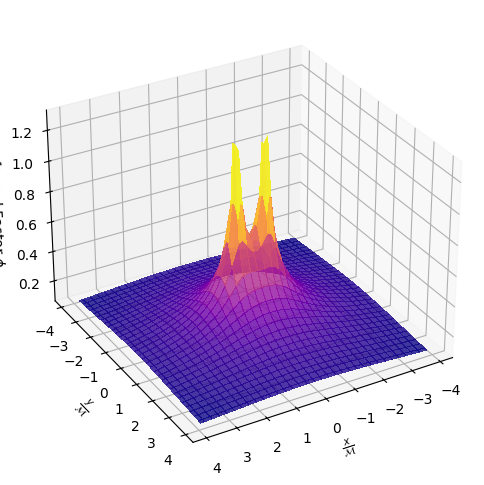

In [70]:
def sort_name(x):
    time_tag = str(x).split("_")[-1]
    number = time_tag.replace("t", "").replace(".npz", "")
    return int(float(number))

array_paths = sorted(list(Path(folder).glob('*.npz')), key=sort_name)
t = [dt * i for i in range(len(array_paths))]

loaded_array = np.load(array_paths[0])
x = loaded_array["X"]
y = loaded_array["Y"]
z = loaded_array["Z"]
func = loaded_array["phi"]

if animate == "chi":
    func = np.exp(-4 * func)
elif animate == "W":
    func = np.exp(-2 * func)

n_grid = x.shape[0]
print("Grid size =",n_grid)

fig = plt.figure(figsize = (8, 6))
ax = plt.axes(projection='3d')
ax.plot_surface(z[:,0,:], 
                y[:,0,:], 
                func[:,n_grid//2,:], 
                cmap=cmap, linewidth=0, antialiased=False, alpha=0.8)
ax.set_xlabel(r'$\frac{x}{\mathcal{M}}$')
ax.set_ylabel(r'$\frac{y}{\mathcal{M}}$')
ax.set_zlabel(rf'Conformal Factor $\{animate}$')
if animate == "W":
    ax.set_zlabel(rf'Conformal Factor ${animate}$')

ax.view_init(30, 60)
plt.show()

### 3D Animation

In [71]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.plot_surface(z[:,0,:], 
                y[:,0,:], 
                func[:,n_grid//2,:], 
                cmap=cmap, linewidth=0, antialiased=False, alpha=0.8)

ax.set_xlabel(r"$\frac{z}{\mathcal{M}}$")
ax.set_ylabel(r"$\frac{y}{\mathcal{M}}$")

plt.close()

def animation_func(i):
    loaded_array = np.load(array_paths[i])
    x = loaded_array["X"]
    y = loaded_array["Y"]
    z = loaded_array["Z"]
    func = loaded_array[animate]
    if animate == "chi":
        func = np.exp(-4 * func)
    elif animate == "W":
        func = np.exp(-2 * func)
    n_grid = x.shape[0]

    ax.clear()
    im = ax.plot_surface(z[:,0,:],
                         y[:,0,:],
                         func[:,n_grid//2,:],
                         cmap=cmap, linewidth=0, antialiased=False, alpha=0.8)

    ax.set_xlabel(r"$\frac{z}{\mathcal{M}}$")
    ax.set_ylabel(r"$\frac{y}{\mathcal{M}}$")
    ax.set_zlabel(rf'Conformal Factor $\{animate}$')
    if animate == "W":
        ax.set_zlabel(rf'Conformal Factor ${animate}$')

    ax.set_title(f"t = {round(t[i], 3)}M")

    return (im,)

print("Funcanimation")
anim3d = animation.FuncAnimation(fig, animation_func, frames=len(array_paths), interval=1/fps * 1e3, blit=True)

print("Saving")
anim3d.save(f'{folder}/Brill Lindquist 3D {animate}.mp4', writer='ffmpeg')
HTML(anim3d.to_html5_video())

Funcanimation
Saving


### 2D Animation

In [72]:
fig = plt.figure()
ax = fig.add_subplot()
ax.set_aspect('equal', adjustable='box')

im = ax.pcolormesh(z[:,0,:],
                   y[:,0,:],
                   func[:,n_grid//2,:],
                   cmap=cmap, shading="nearest")

cb = fig.colorbar(im)
cb.set_label(rf'Conformal Factor $\{animate}$')
if animate == "W":
    cb.set_label(rf'Conformal Factor ${animate}$')

ax.set_xlabel(r"$\frac{z}{\mathcal{M}}$")
ax.set_ylabel(r"$\frac{y}{\mathcal{M}}$")

plt.close()

def animation_func(i):
    loaded_array = np.load(array_paths[i])
    x = loaded_array["X"]
    y = loaded_array["Y"]
    z = loaded_array["Z"]
    func = loaded_array[animate]
    if animate == "chi":
        func = np.exp(-4 * func)
    elif animate == "W":
        func = np.exp(-2 * func)
    n_grid = x.shape[0]

    maximum = np.max(func)
    minimum = np.min(func)
    ax.clear()
    im = ax.pcolormesh(z[:,0,:],
                       y[:,0,:],
                       func[:,n_grid//2,:],
                       cmap=cmap, shading="nearest")

    ax.set_xlabel(r"$\frac{z}{\mathcal{M}}$")
    ax.set_ylabel(r"$\frac{y}{\mathcal{M}}$")

    ax.set_title(f"t = {round(t[i], 3)}M")
    cb.mappable.set_clim(minimum, maximum)

    return (im, )

print("Funcanimation")
anim2d = animation.FuncAnimation(fig, animation_func, frames=len(array_paths), interval=1/fps * 1e3, blit=True)

print("Saving")
anim2d.save(f'{folder}/Brill Lindquist 2D {animate}.mp4', writer='ffmpeg')
HTML(anim2d.to_html5_video())

Funcanimation
Saving


## References

This notebook uses these references:

Alcubierre, M., Brügmann, B., Diener, P., Koppitz, M., Pollney, D., Seidel, E., & Takahashi, R. (2003). Gauge conditions for long-term numerical black hole evolutions without excision. Physical Review D, 67(8), 084023.

Baumgarte, T. W., & Shapiro, S. L. (2010). Numerical relativity: solving Einstein's equations on the computer. Cambridge University Press.

Baumgarte, T. W., & Shapiro, S. L. (2021). Numerical relativity: starting from scratch. Cambridge University Press.

Brügmann, B., González, J. A., Hannam, M., Husa, S., Sperhake, U., & Tichy, W. (2008). Calibration of moving puncture simulations. Physical Review D, 77(2), 024027.

Campanelli, M., Lousto, C. O., Marronetti, P., & Zlochower, Y. (2006). Accurate evolutions of orbiting black-hole binaries without excision. Physical Review Letters, 96(11), 111101.

Cao, Z., Yo, H. J., & Yu, J. P. (2008). Reinvestigation of moving punctured black holes with a new code. Physical Review D, 78(12), 124011.

Harris, C. R., Millman, K. J., Van Der Walt, S. J., Gommers, R., Virtanen, P., Cournapeau, D., ... & Oliphant, T. E. (2020). Array programming with NumPy. Nature, 585(7825), 357-362.

Hunter, J. D. (2007). Matplotlib: A 2D graphics environment. Computing in science & engineering, 9(03), 90-95.

Paszke, A., Gross, S., Massa, F., Lerer, A., Bradbury, J., Chanan, G., ... & Chintala, S. (2019). Pytorch: An imperative style, high-performance deep learning library. Advances in neural information processing systems, 32.

Ruchlin, I., Etienne, Z. B., & Baumgarte, T. W. (2018). SENR/NRPy+: Numerical relativity in singular curvilinear coordinate systems. Physical Review D, 97(6), 064036.

Shibata, M. (2015). Numerical relativity (Vol. 1). World Scientific.

van Meter, J. R., Baker, J. G., Koppitz, M., & Choi, D. I. (2006). How to move a black hole without excision: gauge conditions for the numerical evolution of a moving puncture. Physical Review D, 73(12), 124011.